# Predicting hotel cancellations
![](img/predict-hotel-cancellation.jpg)

*A [DataCamp](https://datacamp.com) challenge* &nbsp;&nbsp;&nbsp;&nbsp;{octicon}`calendar` May, 2023  

{bdg-secondary-line}`Predictive analytics`

## The project

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

Produce recommendations for the hotel on what factors affect whether customers cancel their booking.

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

## Data validation

### Read the data

In [152]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score
from scipy.stats.mstats import winsorize

# Read the data from file
hotels = pd.read_csv("data/hotel_bookings.csv")
print(hotels)

      Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0       INN00001           NaN             NaN                   NaN   
1       INN00002           2.0             0.0                   2.0   
2       INN00003           1.0             0.0                   2.0   
3       INN00004           2.0             0.0                   0.0   
4       INN00005           2.0             0.0                   1.0   
...          ...           ...             ...                   ...   
36270   INN36271           3.0             0.0                   2.0   
36271   INN36272           2.0             0.0                   1.0   
36272   INN36273           2.0             0.0                   2.0   
36273   INN36274           2.0             0.0                   0.0   
36274   INN36275           2.0             0.0                   1.0   

       no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                    NaN               NaN                   

### Check data integrity

In [153]:
# Store initial shape of the dataframe
hotels_init_shape = hotels.shape

# Inspect the dataframe
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          35862 non-null  float64
 2   no_of_children                        35951 non-null  float64
 3   no_of_weekend_nights                  35908 non-null  float64
 4   no_of_week_nights                     35468 non-null  float64
 5   type_of_meal_plan                     35749 non-null  object 
 6   required_car_parking_space            33683 non-null  float64
 7   room_type_reserved                    35104 non-null  object 
 8   lead_time                             35803 non-null  float64
 9   arrival_year                          35897 non-null  float64
 10  arrival_month                         35771 non-null  float64
 11  arrival_date   

#### Duplicates
I will search for duplicate rows while excluding the 'Booking_ID' column, which serves as a unique identifier for each record.

In [154]:
# Complete duplicated rows
print(f'duplicate rows -> {hotels.duplicated().sum()}')

# Check for duplicates excluding unique identifier column
n_duplicates = hotels.duplicated(subset=hotels.columns[1:]).sum()
print(f'duplicate rows (excluding ID) -> {n_duplicates}')

duplicate rows -> 0
duplicate rows (excluding ID) -> 7445


There is a considerable amount of duplicates in relation with the size of the data set.

In [155]:
# Print percentage of duplicates
print(f'{100 * n_duplicates / hotels_init_shape[0]:.0f} % of duplicates')

21 % of duplicates


Since these duplicates have distinct `Booking_ID` identifiers, it is worth considering whether they are actually errors or instead if they represent genuine bookings with identical values. While it's not very likely, especially given the large number of duplicates, it is not impossible that all the variables have repeated values for different bookings. It is worth further investigation to determine the cause of these duplicates.

Anyway, after conducting some exploratory analysis, I could not identify any patterns in the duplicate records. Therefore, to prevent any bias or overfitting issues in the training and test data sets, I will remove all duplicate records and move on.

In [156]:
# Drop duplicated rows keeping only the last
hotels.drop_duplicates(subset=hotels.columns[1:], keep='last', inplace=True)

# Check again for duplicates using subset of columns
print(f'duplicated rows (excluding ID) -> {hotels.duplicated(subset=hotels.columns[1:]).sum()}')
print(f'actual rows of dataframe -> {hotels.shape[0]}')

duplicated rows (excluding ID) -> 0
actual rows of dataframe -> 28830


#### Missing values

In [157]:
# Check for missing values
hotels.isna().sum().sort_values(ascending=False)

required_car_parking_space              2465
market_segment_type                     1486
room_type_reserved                      1137
arrival_date                             946
no_of_week_nights                        788
no_of_special_requests                   782
repeated_guest                           575
no_of_previous_bookings_not_canceled     547
type_of_meal_plan                        519
arrival_month                            503
no_of_previous_cancellations             492
lead_time                                470
avg_price_per_room                       452
no_of_adults                             408
arrival_year                             373
no_of_weekend_nights                     367
no_of_children                           318
Booking_ID                                 0
booking_status                             0
dtype: int64

There are quite a number of missing values. Let's take a look at the missingness matrix.

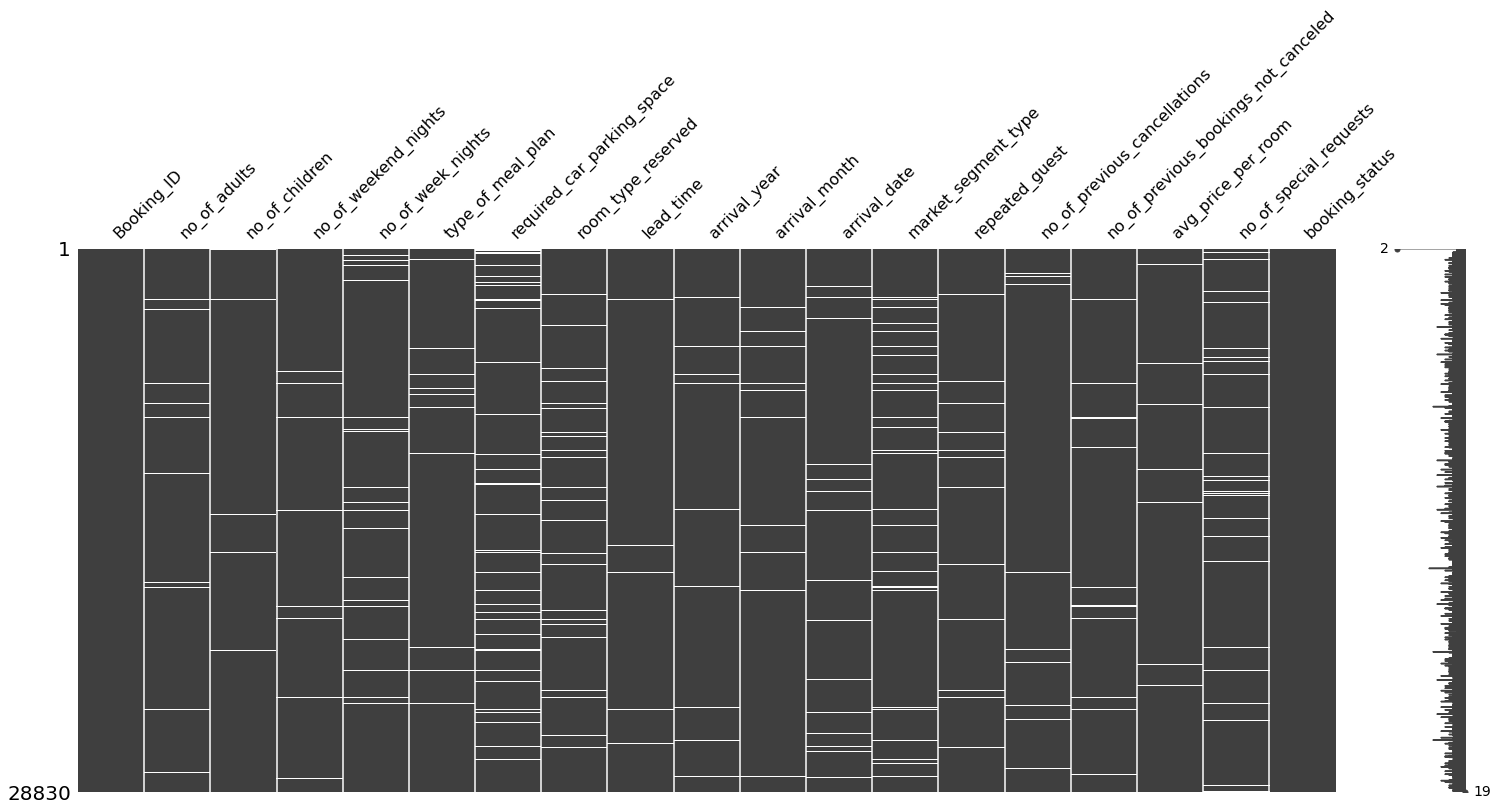

In [158]:
# Visualize missingness matrix
msno.matrix(hotels)
plt.show()

Before going with the columns, I will start by checking rows with multiple missing values.

In [159]:
# Rows with multiple missing values
hotels.isna().sum(axis=1).sort_values(ascending=False).head(10)

0        17
22176     9
33264     8
11088     8
27720     8
16632     7
5544      7
7392      7
29568     7
15840     7
dtype: int64

I will drop the first row because all its values are missing.

In [160]:
# Drop the first row
hotels.drop(0, inplace=True)

I am going to proceed checking missing values by columns and deciding how to deal with them in each case.

Let's start with the column with the maximum number of missing values: `required_car_parking_space`.

In [161]:
# Look at the unique values
list(hotels['required_car_parking_space'].unique())

[0.0, nan, 1.0]

In this case it makes sense to assign missing values to '0' (not required car parking space).

In [162]:
# Fill missing values
hotels["required_car_parking_space"].fillna(0, inplace=True)

The next column with multiple missing values is `market_segment_type` (how the booking was made).

In [163]:
# Look at the unique values
list(hotels['market_segment_type'].unique())

['Online', 'Offline', nan, 'Aviation', 'Complementary', 'Corporate']

I could create a new category for missing values, but first I am going to sort the data frame by this column to see if there are structural paterns related to them.

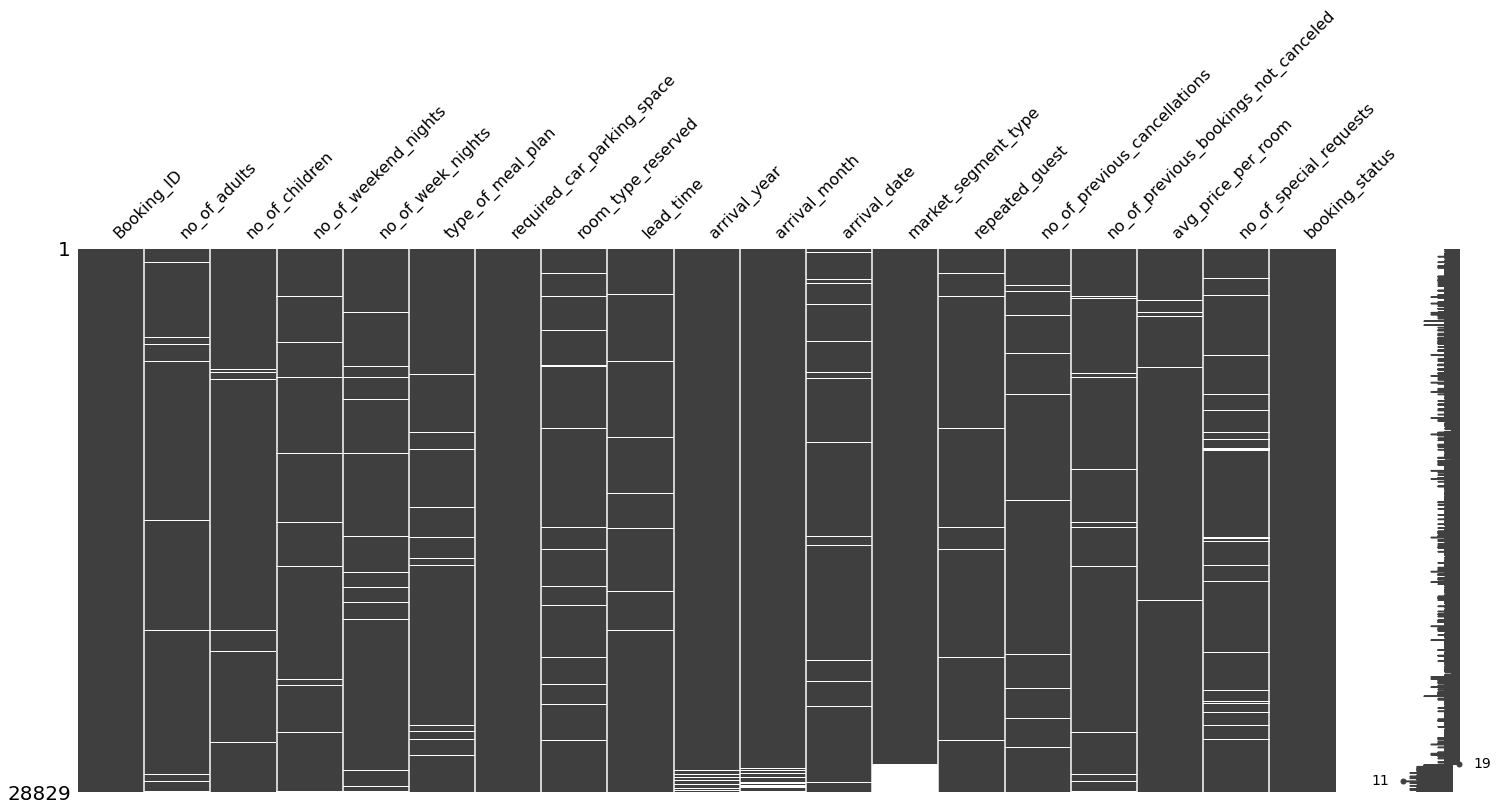

In [164]:
# Visualize missingness matrix
msno.matrix(hotels.sort_values('market_segment_type'))
plt.show()

In the matrix, we can see that missing values in the `market_segment_type` column come in the same rows in which all of the missing values in `arrival_year` and `arrival_month` are present. Because of that, I have decided to remove all those rows, to get rid of those missing values.

In [165]:
# Drop rows with missing values in column
hotels.dropna(subset='market_segment_type', inplace=True)

Let's take a look at missing values in `room_type_reserved`.

In [166]:
# Look at the unique values
list(hotels['room_type_reserved'].unique())

['Room_Type 1',
 'Room_Type 4',
 nan,
 'Room_Type 2',
 'Room_Type 6',
 'Room_Type 7',
 'Room_Type 5',
 'Room_Type 3']

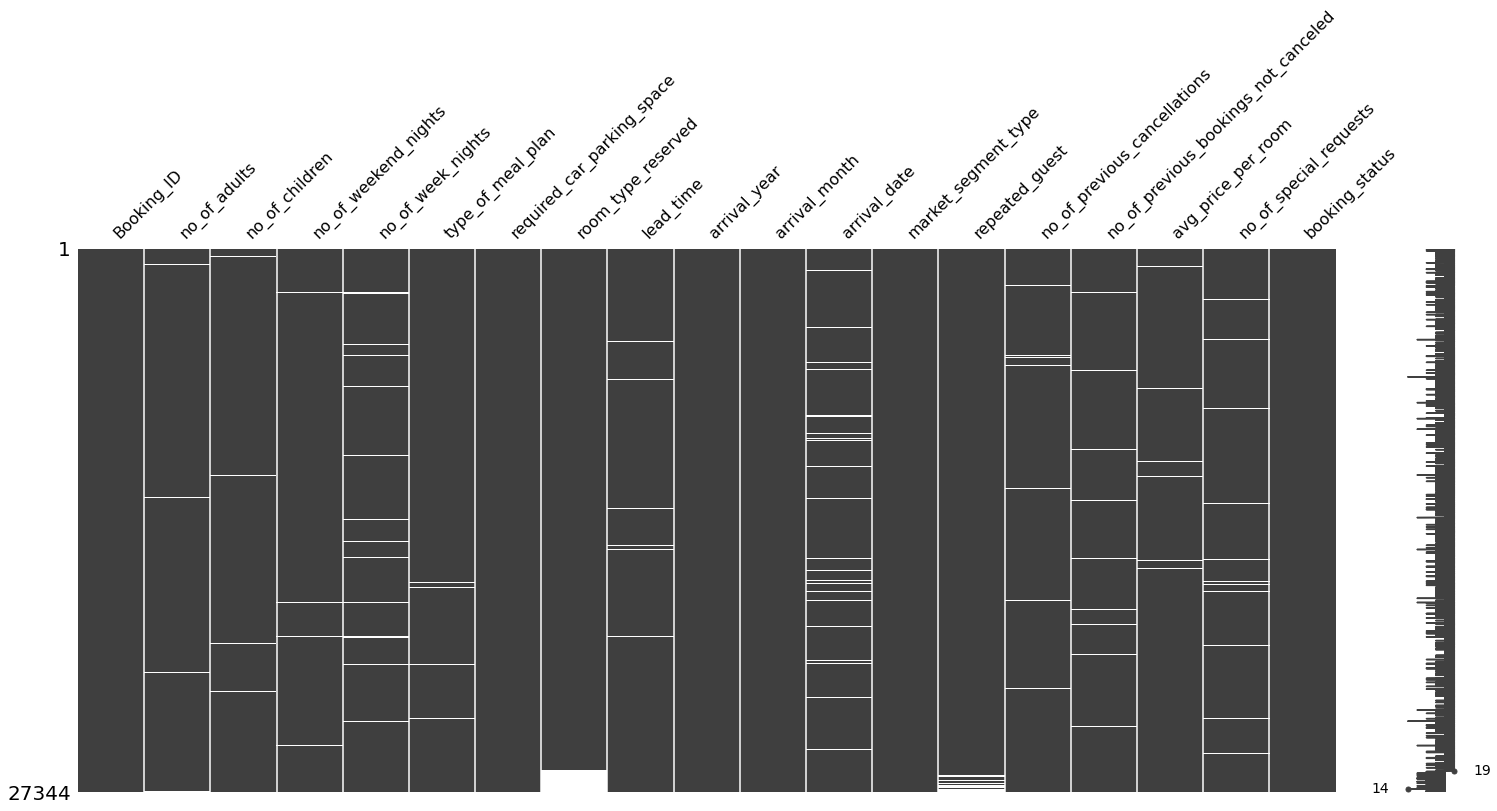

In [167]:
# Visualize missingness matrix
msno.matrix(hotels.sort_values('room_type_reserved'))
plt.show()

As in the previous case, I am not going to create a new category for missing values in `room_type_reserved` because they come along with missign values in `repeated_guest`, so I will get rid of all of them.

In [168]:
# Drop rows with missing values in column
hotels.dropna(subset='room_type_reserved', inplace=True)

Let's take a lok at the next most numerous missing values column, `arrival_date`.

In [169]:
# Look at the unique values
hotels['arrival_date'].unique()

array([ 6., 11., 15., 18., 30., 26., 20.,  5., 10., 28., 19.,  7.,  9.,
       27., nan,  1., 21., 29., 16., 13.,  2.,  3., 25., 14.,  4., 17.,
       22., 23., 31.,  8., 12., 24.])

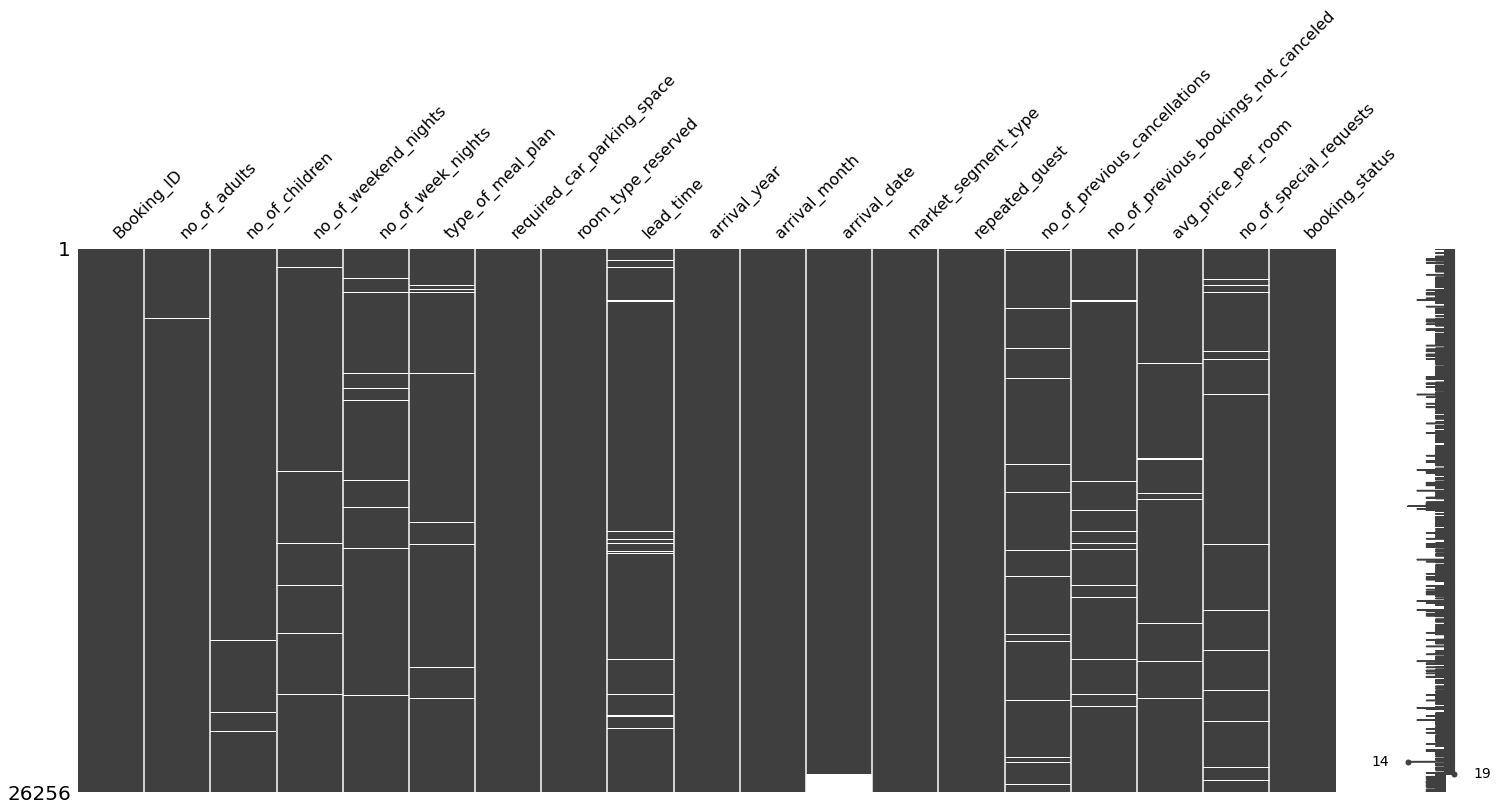

In [170]:
# Visualize missingness matrix
msno.matrix(hotels.sort_values('arrival_date'))
plt.show()

Missing values in `arrival_date` do not come along with any other significant number of missing values in other columns in the same row. After inspecting the data frame, I cannot see any pattern for these rows in any other column, so I will directly drop those rows.

In [171]:
# Drop rows with missing values in column
hotels.dropna(subset='arrival_date', inplace=True)

Let's take a look at the next column with more missing values: `no_of_week_nights`. This values could be related to the column `no_of_weekend_nights`, so let's consider them together.

In [172]:
# Look at the unique values
print(f"Week nights -> {hotels['no_of_week_nights'].unique()}")
print(f"Weekend nights -> {hotels['no_of_weekend_nights'].unique()}")

Week nights -> [ 3.  1.  4.  5.  0.  2. nan 10.  6. 11.  7. 15.  9. 13.  8. 14. 12. 17.
 16.]
Weekend nights -> [ 2.  1.  0. nan  4.  3.  6.  5.]


I will follow this criteria to solve missing values in these two columns:
- If both are missing, I will drop that row.
- If one of them is missing and the value of the other one is 0, then I will drop that row.
- If one of them is missing and the value of the other one is not 0, then I will assign 0.

In [173]:
# Drop rows with missing values in both column
hotels.dropna(subset=['no_of_week_nights', 'no_of_weekend_nights'], how='all', inplace=True)

# Drop if missing value in one column and 0 in the other
hotels.drop(hotels[(hotels['no_of_week_nights'].isna())\
                   & (hotels['no_of_weekend_nights'] == 0)].index, inplace=True)
hotels.drop(hotels[(hotels['no_of_weekend_nights'].isna())\
                   & (hotels['no_of_week_nights'] == 0)].index, inplace=True)

# Assign value 0 if missing value but the other column has a non-zero value
hotels.loc[(hotels['no_of_week_nights'].isna())\
           & (hotels['no_of_weekend_nights'] != 0),
           'no_of_week_nights'] = 0

hotels.loc[(hotels['no_of_week_nights'] != 0)\
           & (hotels['no_of_weekend_nights'].isna()),
           'no_of_weekend_nights'] = 0

Let's take a look at the next one: `no_of_special_requests`.

In [174]:
# Look at the unique values
hotels['no_of_special_requests'].unique()

array([ 1.,  0.,  3.,  2., nan,  4.,  5.])

It makes sense to assign '0' to missing values in this column.

In [175]:
# Fill missing values in column
hotels['no_of_special_requests'].fillna(0, inplace=True)

Let's take a look at `type_of_meal_plan`.

In [176]:
# Look at the unique values
hotels['type_of_meal_plan'].unique()

array(['Not Selected', 'Meal Plan 1', nan, 'Meal Plan 2', 'Meal Plan 3'],
      dtype=object)

I will assign missing values to 'Not Selected' category.

In [177]:
# Fill missing values in column
hotels['type_of_meal_plan'].fillna('Not Selected', inplace=True)

I will directly drop rows with `lead_time` missing values and also with missing values in `avg_price_per_room`.

In [178]:
# Drop rows with missing values in column
hotels.dropna(subset='lead_time', inplace=True)

# Drop rows with missing values in column
hotels.dropna(subset='avg_price_per_room', inplace=True)

Let's now take a look at the `no_of_adults` and `no_of_children` columns. I will use the following criteria:
- I will drop rows with missing values in `no_of_adults`.
- I will assign '0' to missing `no_of_children` if `no_of_adults` is not '0'.

In [179]:
# Drop rows with missing values in column
hotels.dropna(subset='no_of_adults', inplace=True)

# Assign value 0 if missing value but the other column has a non-zero value
hotels.loc[(hotels['no_of_children'].isna()) & (hotels['no_of_adults'] != 0),
           'no_of_children'] = 0

# Fill missing values in column
hotels.dropna(subset='no_of_children', inplace=True)

Let's take a look at (finally!) the last features with missing values: `no_of_previous_cancellations` and `no_of_previous_bookings_not_canceled`.

In [180]:
# Look at the unique values
hotels['no_of_previous_cancellations'].unique()

array([ 0., nan,  3.,  1.,  2., 11.,  4.,  5.,  6., 13.])

In [181]:
# Look at the unique values
hotels['no_of_previous_bookings_not_canceled'].unique()

array([ 0., nan,  5.,  1.,  3.,  4., 12., 19.,  2., 15., 17.,  7., 20.,
       16., 50., 13.,  6., 14., 34., 18., 10., 23., 11.,  8., 49., 47.,
       53.,  9., 33., 24., 52., 22., 21., 48., 28., 39., 25., 31., 38.,
       51., 42., 37., 35., 56., 44., 27., 32., 55., 26., 45., 30., 57.,
       46., 54., 43., 58., 41., 29., 40., 36.])

I will direclty drop rows with missing values.

In [182]:
# Drop rows with missing values in column
hotels.dropna(subset=['no_of_previous_cancellations',
                      'no_of_previous_bookings_not_canceled'], how='any', inplace=True)

Finally, let's confirm that we have removed all missing values.

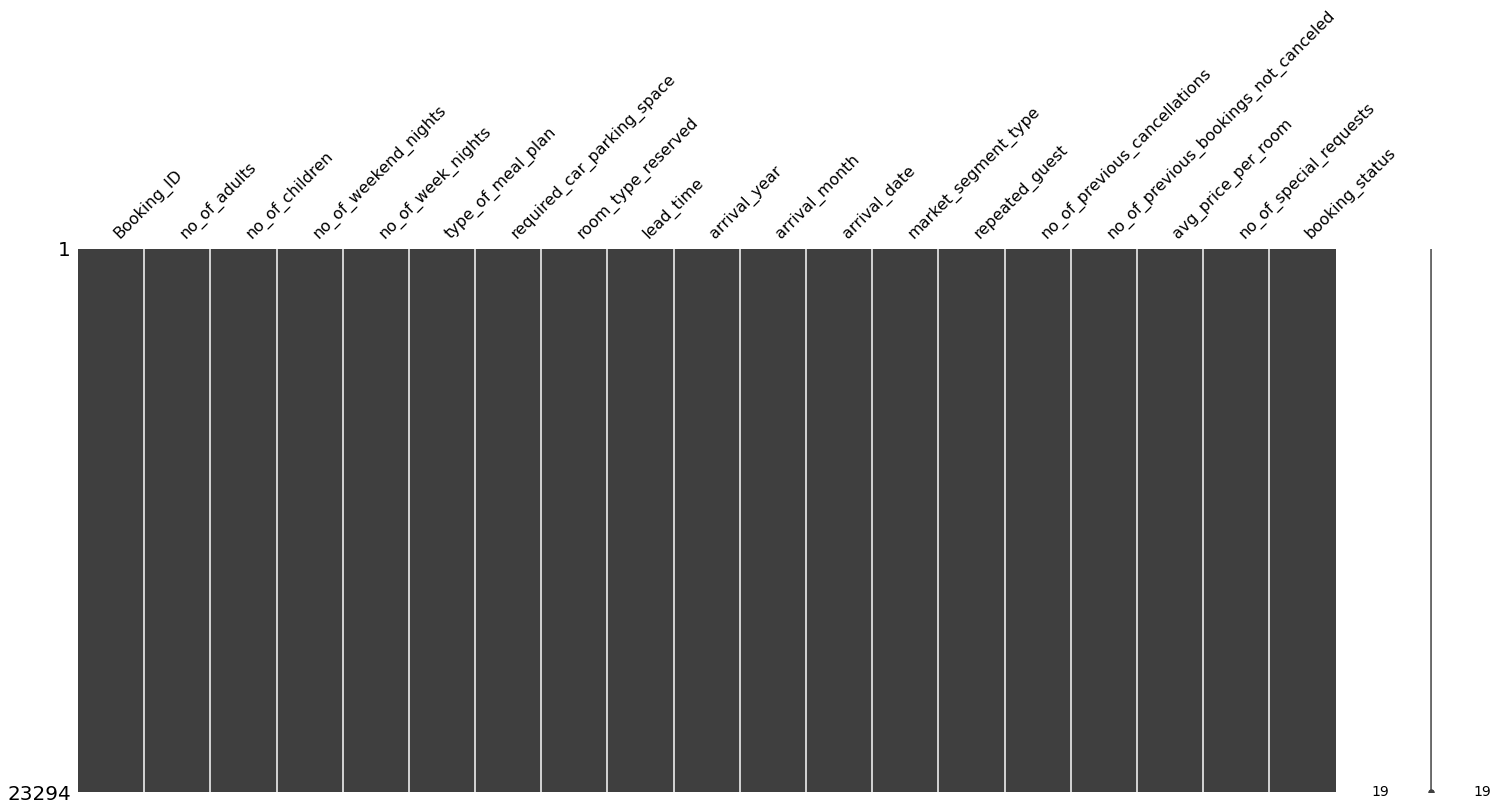

In [183]:
# Visualize missingness matrix
msno.matrix(hotels)
plt.show()

In [184]:
# Check for missing values
hotels.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

All clean now!

After cleanning the data from duplicates and missing values the data frame has been reduced to:

In [185]:
# Print actual data frame size
print(f'Actual rows -> {hotels.shape[0]}')
print(f'{100 * hotels.shape[0] / hotels_init_shape[0]:.0f} % of the initial rows')

Actual rows -> 23294
64 % of the initial rows


###  Data consistency

I am going to explore date consistency by creating a new column with datetime format. The function will attempt to convert the year, month, and day into a valid date. If an error occurs, the date will be converted into a missing value.

In [186]:
# Create new column 'date', coerce errors to detect date inconsistencies
hotels['date'] = pd.to_datetime(dict(year=hotels['arrival_year'],
                                     month=hotels['arrival_month'],
                                     day=hotels['arrival_date']),
                                errors='coerce')

# Sum date inconsistencies (coerced errors are set to 'nan')
hotels['date'].isna().sum()

31

Let's find out what these date inconsistencies are about.

In [187]:
# Print date errors
print(hotels.loc[hotels['date'].isna(), ['arrival_year', 'arrival_month', 'arrival_date']])

       arrival_year  arrival_month  arrival_date
2626         2018.0            2.0          29.0
3677         2018.0            2.0          29.0
5600         2018.0            2.0          29.0
7648         2018.0            2.0          29.0
8000         2018.0            2.0          29.0
9153         2018.0            2.0          29.0
9245         2018.0            2.0          29.0
9664         2018.0            2.0          29.0
9934         2018.0            2.0          29.0
10593        2018.0            2.0          29.0
10652        2018.0            2.0          29.0
10747        2018.0            2.0          29.0
11881        2018.0            2.0          29.0
13958        2018.0            2.0          29.0
15363        2018.0            2.0          29.0
17202        2018.0            2.0          29.0
18380        2018.0            2.0          29.0
18534        2018.0            2.0          29.0
18680        2018.0            2.0          29.0
19013        2018.0 

The year '2018' was not a leap year, so these entries with date '2018-02-29' are incorrect. I will drop them.

In [188]:
# Drop rows of unexisting date 2018-02-29
hotels.drop(hotels[(hotels['arrival_year'] == 2018) \
                   & (hotels['arrival_month'] == 2) \
                   & (hotels['arrival_date'] == 29)].index, inplace=True)

# Drop no longer necessary auxiliary column 'date'
hotels.drop('date', axis=1, inplace=True)

### Check categorical variables
Let’s see if variables of type ‘object’ (strings) contain categories.

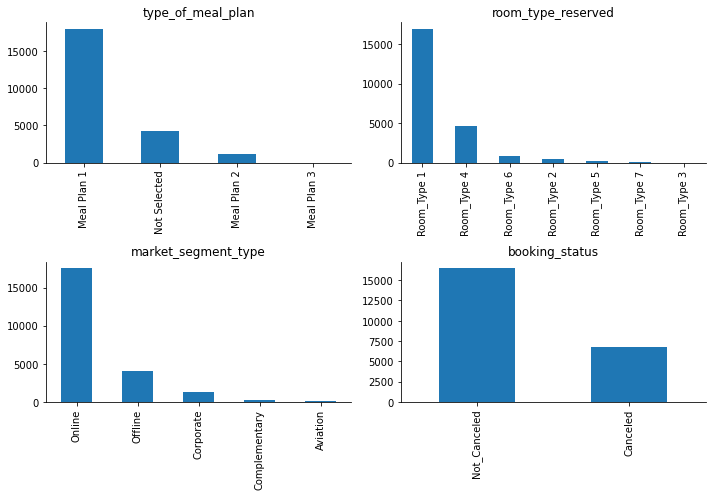

In [189]:
# Select column names of object type, excluding ID column
object_cols = hotels.select_dtypes(include="object").columns[1:]

# Plot their values and counts
fig, ax= plt.subplots(int(len(object_cols) / 2), 2, figsize=(10, 7))
i = 0
for col in object_cols:
    x = int(i / 2)
    y = i % 2
    sns.despine()
    hotels[col].value_counts().plot(ax=ax[x, y], kind='bar')
    ax[x, y].set_title(col)
    i += 1

fig.tight_layout()
plt.show()

The target variable, `booking_status`, is quite imbalanced, with the class of interest, ‘canceled’, being less represented than the other class. I am going to replace the values in the target variable from ‘Not_Canceled-Canceled’ to numerical ‘0-1’ right away (without waiting for the creation of dummies) because it will facilitate some early analysis.

In [190]:
# Replace to numerical values
hotels['booking_status'] = hotels['booking_status'].replace({'Not_Canceled': 0, 'Canceled': 1})\
                        .astype('int')

All the remaining ‘object’ columns can be converted to categorical.

In [191]:
# Create a dictionary of column and data type mappings
conversion_dict = {k: "category" for k in hotels.select_dtypes(include="object").columns[1:]}

# Convert our DataFrame and check the data types
hotels = hotels.astype(conversion_dict)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23263 entries, 1 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Booking_ID                            23263 non-null  object  
 1   no_of_adults                          23263 non-null  float64 
 2   no_of_children                        23263 non-null  float64 
 3   no_of_weekend_nights                  23263 non-null  float64 
 4   no_of_week_nights                     23263 non-null  float64 
 5   type_of_meal_plan                     23263 non-null  category
 6   required_car_parking_space            23263 non-null  float64 
 7   room_type_reserved                    23263 non-null  category
 8   lead_time                             23263 non-null  float64 
 9   arrival_year                          23263 non-null  float64 
 10  arrival_month                         23263 non-null  float64 
 11  ar

### Check numerical variables
Numerical variables are all integer type, except fot the `avg_price_per_room`, which I will leave as float type.

In [192]:
# Create a dictionary of column and data type mappings
conversion_dict = {k: 'int' for k in hotels.select_dtypes(include='float64').columns}

# Remove element to maintain as float
del conversion_dict['avg_price_per_room']

# Convert our DataFrame and check the data types
hotels = hotels.astype(conversion_dict)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23263 entries, 1 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Booking_ID                            23263 non-null  object  
 1   no_of_adults                          23263 non-null  int32   
 2   no_of_children                        23263 non-null  int32   
 3   no_of_weekend_nights                  23263 non-null  int32   
 4   no_of_week_nights                     23263 non-null  int32   
 5   type_of_meal_plan                     23263 non-null  category
 6   required_car_parking_space            23263 non-null  int32   
 7   room_type_reserved                    23263 non-null  category
 8   lead_time                             23263 non-null  int32   
 9   arrival_year                          23263 non-null  int32   
 10  arrival_month                         23263 non-null  int32   
 11  ar

Let's plot numerical data ranges.

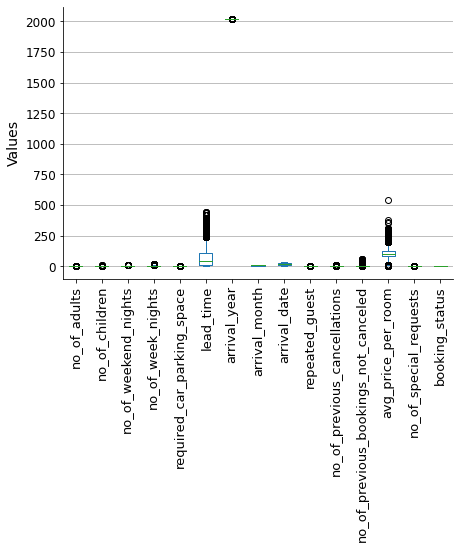

In [193]:
# Plot
fig, ax = plt.subplots(figsize=(7, 5))

hotels[hotels.select_dtypes(include=['int', 'float']).columns].plot(ax=ax, kind='box')

sns.despine()
ax.grid(axis="y")
ax.set_axisbelow(True)

ax.set_ylabel('Values', fontsize=14)

ax.tick_params(axis='x', labelsize=13, rotation=90)
ax.tick_params(axis='y', labelsize=12)

plt.show()

We can see that `arrival_year` has data out of the range. This is simply because we are dealing with year numbers. In reality, this variable should be considered categorical instead of numerical, it only has two year values.

In [194]:
# Print unique values
print(list(hotels['arrival_year'].unique()))

# Convert to 'category'
hotels['arrival_year'] = hotels['arrival_year'].astype('category')

[2018, 2017]


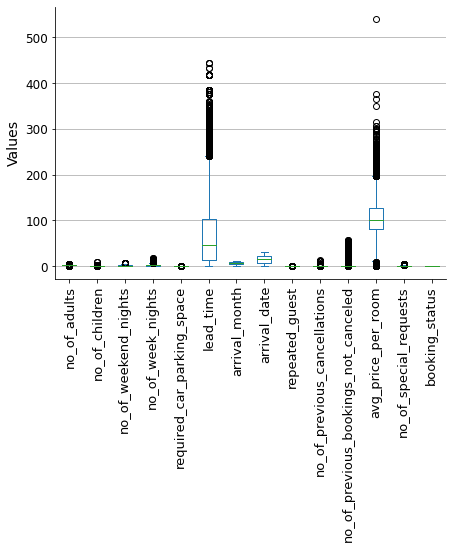

In [195]:
# Plot
fig, ax = plt.subplots(figsize=(7, 5))

hotels[hotels.select_dtypes(include=['int', 'float']).columns].plot(ax=ax, kind='box')

sns.despine()
ax.grid(axis="y")
ax.set_axisbelow(True)

ax.set_ylabel('Values', fontsize=14)

ax.tick_params(axis='x', labelsize=13, rotation=90)
ax.tick_params(axis='y', labelsize=12)

plt.show()

To reduce the impact of outliers on the model outcome, I will use the *winsorization* method to filter them out. This will limit the extreme values to lower and upper limits based on percentiles. I will use a 5% limit for both the upper and lower bounds.

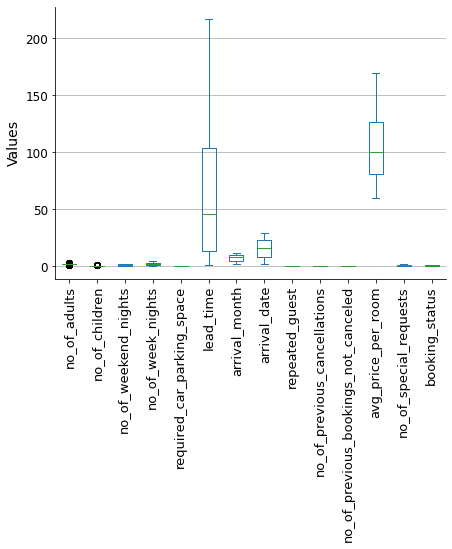

In [196]:
# Filter outliers with winsorization
limit = 0.05
for col in hotels.select_dtypes(include=['int', 'float']).columns:
    hotels[col] = winsorize(hotels[col], limits = [limit, limit])
    
# Plot resulting box plot
fig, ax = plt.subplots(figsize=(7, 5))

hotels[hotels.select_dtypes(include=['int', 'float']).columns].plot(ax=ax, kind='box')

sns.despine()
ax.grid(axis="y")
ax.set_axisbelow(True)

ax.set_ylabel('Values', fontsize=14)

ax.tick_params(axis='x', labelsize=13, rotation=90)
ax.tick_params(axis='y', labelsize=12)

plt.show()

We are now ready to proceed with the analysis!

## Predictive analysis

### Data preprocessing
This process consists of:
1. Separating variables (features) and target.
2. Converting categorical variables to numerical (avoiding multicollinearity).
3. Splitting the data into training and testing sets.
4. Scaling the data (necessary for Logistic Regression).
5. Reconstructing complete basetables (features + target) to perform predictive analysis.

In [197]:
# Define features
features = hotels.drop(['Booking_ID', 'booking_status'], axis=1)

# Define target
target = hotels['booking_status']

# Prepare features encoding categorical variables
X = pd.get_dummies(features,
                   drop_first=True) # Avoid multicollinearity

# Assign target
y = target

# Split dataset into 70% training and 30% test set, and stratify
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

# Scale X
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Reset index to concatenate later
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Create the train and test basetables
train = pd.concat([X_train_scaled, y_train], axis=1)
test = pd.concat([X_test_scaled, y_test], axis=1)

### Variable selection
Once we have the train and test basetables ready, we can proceed with the process of selecting the variables that have the highest predictive power.

To do so, I will use a *forward stepwise variable selection procedure*, in which AUC scores are considered as a metric. Variables will be sorted according to the predictive power achieved if we include them progressively in a Logistic Regression model. The process will be carried out only in the training basetable to avoid data leakage.

In [198]:
# Define funtion
def auc(variables, target, basetable):
    '''Returns AUC of a Logistic Regression model'''
    X = basetable[variables]
    y = np.ravel(basetable[target])
    logreg = LogisticRegression()
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

# Define funtion
def next_best(current_variables,candidate_variables, target, basetable):
    '''Returns next best variable to maximize AUC'''
    best_auc = -1
    best_variable = None
    for v in candidate_variables:
        auc_v = auc(current_variables + [v], target, basetable)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
    return best_variable

# Define funtion
def auc_train_test(variables, target, train, test):
    '''Returns AUC of train and test data sets'''
    return (auc(variables, target, train), auc(variables, target, test))


# Define candidate variables
candidate_variables = list(train.columns)
candidate_variables.remove("booking_status")

# Initialize current variables
current_variables = []

# The forward stepwise variable selection procedure
number_iterations = len(candidate_variables) # All variables will be considered

for i in range(0, number_iterations):
    # Get next variable which maximizes AUC in the training data set
    next_variable = next_best(current_variables, candidate_variables, ["booking_status"], train)
    # Add it to the list
    current_variables = current_variables + [next_variable]
    # Remove it from the candidate variables' list
    candidate_variables.remove(next_variable)
    # Print which variable was added
    print(f"Step {i + 1}: variable '{next_variable}' added")

Step 1: variable 'lead_time' added
Step 2: variable 'no_of_special_requests' added
Step 3: variable 'market_segment_type_Online' added
Step 4: variable 'avg_price_per_room' added
Step 5: variable 'arrival_year_2018' added
Step 6: variable 'market_segment_type_Offline' added
Step 7: variable 'arrival_month' added
Step 8: variable 'room_type_reserved_Room_Type 2' added
Step 9: variable 'market_segment_type_Complementary' added
Step 10: variable 'market_segment_type_Corporate' added
Step 11: variable 'type_of_meal_plan_Not Selected' added
Step 12: variable 'no_of_weekend_nights' added
Step 13: variable 'no_of_week_nights' added
Step 14: variable 'type_of_meal_plan_Meal Plan 2' added
Step 15: variable 'type_of_meal_plan_Meal Plan 3' added
Step 16: variable 'room_type_reserved_Room_Type 5' added
Step 17: variable 'room_type_reserved_Room_Type 6' added
Step 18: variable 'no_of_children' added
Step 19: variable 'room_type_reserved_Room_Type 7' added
Step 20: variable 'room_type_reserved_Room_

We will now visualize the performance evolution as variables are included in the model in the order defined by the list. We will consider both the train and test basetables to check the validity of the results.

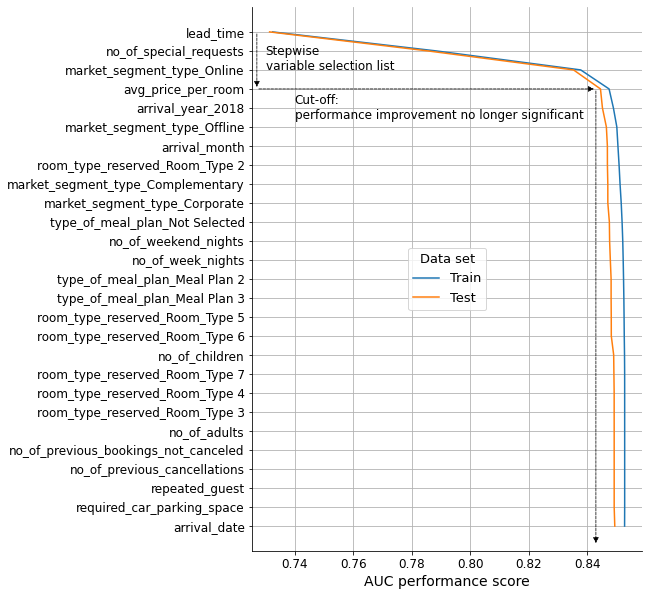

In [199]:
# Init lists
auc_values_train = []
auc_values_test = []
variables_evaluate = []

# Iterate over the variables in variables
for v in current_variables:
  
    # Add the variable
    variables_evaluate.append(v)
    
    # Calculate the train and test AUC of this set of variables
    auc_train, auc_test = auc_train_test(variables_evaluate, ["booking_status"], train, test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

# Create dataframe to plot results
aucs = pd.concat([pd.DataFrame(np.array(auc_values_train),
                               columns=['Train'],
                               index=current_variables),
                  pd.DataFrame(np.array(auc_values_test),
                               columns=['Test'],
                               index=current_variables)],
                 axis=1)

# Plot
fig, ax = plt.subplots(figsize=(7, 10))

ax.plot(aucs['Train'], aucs.index, label='Train')
ax.plot(aucs['Test'], aucs.index, label='Test')

sns.despine()
ax.grid(axis="both")
ax.set_axisbelow(True)

ax.set_title('', fontsize=14)
ax.set_xlabel('AUC performance score', fontsize=14)
ax.set_ylabel("", fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Data set', loc='center', title_fontsize=13, fontsize=13)

ax.annotate('',
            xy=(0.727, 3),
            xytext=(0.727, 0), fontsize=12,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linewidth': '0.75','linestyle':"--"})

ax.annotate('',
            xy=(0.843, 3), 
            xytext=(0.727, 3), fontsize=12,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linewidth': '0.75','linestyle':"--"})

ax.annotate('',
            xy=(0.843, 27), 
            xytext=(0.843, 3), fontsize=12,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linewidth': '0.75','linestyle':"--"})

ax.annotate("Stepwise\nvariable selection list", (0.73, 2), size=12)
ax.annotate("Cut-off:\nperformance improvement no longer significant", (0.74, 4.6), size=12)

ax.invert_yaxis()

plt.show()

# Selected variables
n_variables = 4
selected_variables = current_variables[:n_variables]

After conducting the forward stepwise variable selection procedure, a total of **4 variables** were selected based on their predictive power.

1. `lead_time`
2. `no_of_special_requests`
3. `market_segment_type_Online`
4. `avg_price_per_room`

To ensure that we are not missing any important variables, I will compare the accuracy, precision, and recall scores of the Logistic Regression model when fitted with all variables vs when fitted only with the 4 selected ones.

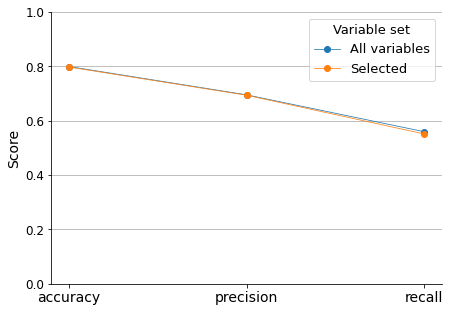

In [200]:
# Fit Logistic Regression model with all variables
scores_all = []
logreg_all = LogisticRegression()
logreg_all.fit(X_train_scaled, y_train)
y_pred_all = logreg_all.predict(X_test_scaled)
scores_all.append(accuracy_score(y_test, y_pred_all))
scores_all.append(precision_score(y_test, y_pred_all))
scores_all.append(recall_score(y_test, y_pred_all))

# Fit Logistic Regression model with selected variables only
scores_sel = []
logreg_sel = LogisticRegression()
logreg_sel.fit(X_train_scaled.loc[:, selected_variables], y_train)
y_pred_sel = logreg_sel.predict(X_test_scaled.loc[:, selected_variables])
scores_sel.append(accuracy_score(y_test, y_pred_sel))
scores_sel.append(precision_score(y_test, y_pred_sel))
scores_sel.append(recall_score(y_test, y_pred_sel))

# Create dataframe for plotting
metrics = pd.DataFrame(scores_all,
                       index=['accuracy', 'precision', 'recall'], columns=['all'])
metrics['sel'] = scores_sel

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

metrics.plot(ax=ax, marker='o', linewidth=0.75)

sns.despine()
ax.grid(axis="y")
ax.set_axisbelow(True)

ax.set_title('', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Score', fontsize=14)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(range(0, 3), labels=list(metrics.index))

ax.legend(title='Variable set', labels=['All variables', 'Selected'],
          loc='upper right', title_fontsize=13, fontsize=13)
ax.set_ylim(0, 1)

plt.show()

This comparison tells that we are not losing significant predictive information if we only consider the selected variables.

Coefficients of the Logistic Regression model tell us about the importance of each of the variables.

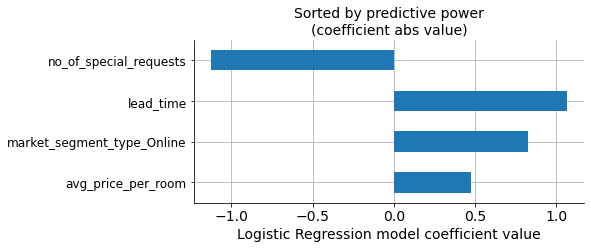

In [201]:
# Extract coefficients of the model fitted with selected variables
coefs = pd.DataFrame(logreg_sel.coef_[0],
                    index=X_train_scaled.loc[:, selected_variables].columns)\
                    .rename(columns={0: 'logreg_coef'})

# Add new column with their absolute value
coefs['coef_abs'] = coefs['logreg_coef'].abs()

# Sort data frame according to the absolute values
coefs = coefs.sort_values('coef_abs', ascending=False)

# Add new column with their position in the model coefficients list
coefs['coef_abs_pos'] = range(1, len(coefs) + 1)

# Plot
fig, ax = plt.subplots(figsize=(7, 3))

coefs['logreg_coef'].plot(kind='barh')

sns.despine()
ax.grid(axis="both")
ax.set_axisbelow(True)

ax.set_title('Sorted by predictive power\n(coefficient abs value)', fontsize=14)
ax.set_xlabel('Logistic Regression model coefficient value', fontsize=14)
ax.set_ylabel('', fontsize=14)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.invert_yaxis()

plt.show()

In the graph, we can see the values of the coefficients for each variable, sorted according to their absolute values (predictive power).

However, we selected our own list of variables based on the model performance’s progressive improvement. We can see that both lists have the same variables, but the order of importance is not exactly the same.

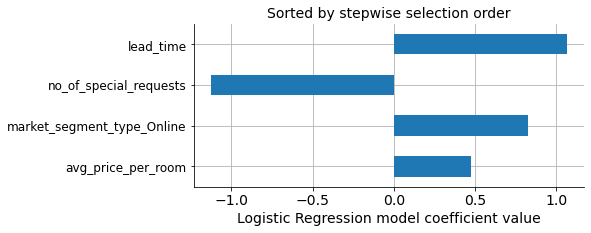

In [202]:
# Create another dataframe with selected variables
sel_vars = pd.DataFrame(selected_variables, columns=['selection'])

# Add column with their position in the selected variable list
sel_vars['selection_pos'] = range(1, len(sel_vars) + 1)

# Set index to prepare for the merging
sel_vars = sel_vars.set_index('selection')

# Merge both dataframes on the indexes
coefs_sels = coefs.merge(sel_vars, how='left', left_index=True, right_index=True)

coefs_sels_ = coefs_sels.sort_values('selection_pos')

# Plot
fig, ax = plt.subplots(figsize=(7, 3))

coefs_sels_['logreg_coef'].plot(kind='barh')

sns.despine()
ax.grid(axis="both")
ax.set_axisbelow(True)

ax.set_title('Sorted by stepwise selection order', fontsize=14)
ax.set_xlabel('Logistic Regression model coefficient value', fontsize=14)
ax.set_ylabel('', fontsize=14)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.invert_yaxis()

plt.show()

In our selection `lead_time` comes first instead of `no_of_special_requests` as the most important predictive variable.

### Predictor Insight Graphs
Let's finish our analysis plotting the *Predictor Insight Graphs* for the selected variables, to verify whether the variables in the model are interpretable and the results make sense.

In [203]:
# Define plotting function
def plot_pig(df, variable, target, sort=False, rotation=0):
    '''Create and plot Predictor Insight Graph for corresponding variable'''
    
    # Create Predictor Insight Graph table
    pig_table = df.groupby(variable)[target].agg([np.size, np.mean])
    
    # If sort values
    if sort:
        pig_table = pig_table.sort_values('size', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    ax2 = ax.twinx()
    
    pig_table['size'].plot(ax=ax, kind='bar', color='lightgrey')
    ax2.plot(ax.get_xticks(), pig_table['mean'], marker='o', linewidth=0.75, color='black')
    
    sns.despine()
    ax2.grid(axis="y")
    ax.set_axisbelow(True)
    
    ax.set_title('', fontsize=14)
    ax.set_xlabel(variable, fontsize=14)
    ax.set_ylabel('Size', fontsize=14)
    ax2.set_ylabel('Incidence ', fontsize=14)
    
    ax.tick_params(axis='x', labelsize=13, rotation=rotation)
    ax.tick_params(axis='y', labelsize=12)
    ax2.set_yticks(np.arange(0, 1.25, 0.25), labels=np.arange(0, 1.25, 0.25))
    
    ax.set_ylim(0)
    ax2.set_ylim(0, 1)
    
    plt.show()
    
    return pig_table

# Take complete basetable with dummies
hotels_dummied = pd.get_dummies(hotels, drop_first=True)

Let's begin with `lead_time`. This is a continuous variable that has many unique values, so we need to discretize it (define intervals and group values into those intervals) before plotting.

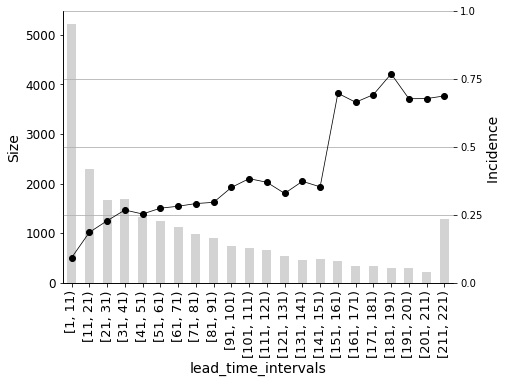

In [204]:
# Check minimum and maximum values to define range
hotels_dummied['lead_time'].agg([min, max])

# Establish lead time intervals according to value ranges
bins = pd.IntervalIndex.from_tuples([(i, i + 10) for i in range(1, 220, 10)], closed='left')

# Create new column with time intervals
hotels_dummied['lead_time_intervals'] = pd.cut(hotels_dummied['lead_time'], bins)

# Plot
_ = plot_pig(hotels_dummied, 'lead_time_intervals', 'booking_status', rotation=90)

When the `lead_time` (the number of days between the booking date and the arrival date) increases, there is also an increase in the incidence on the target (`booking_status` -> '1': 'Cancelled') as shown in the graph. This effect is particularly pronounced when the `lead_time` is more than three months, as the cancellation ratio increases dramatically.

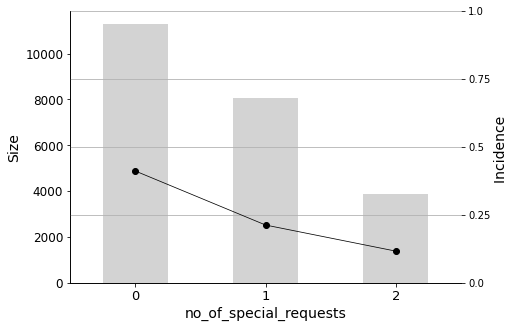

In [205]:
# Plot
_ = plot_pig(hotels_dummied, 'no_of_special_requests', 'booking_status')

The variable `no_of_special_requests` is negatively correlated with the target (the coefficient in the Logistic Regression model was negative), which means that the more requests a customer makes as part of the booking, the greater the incidence on the cancellation.

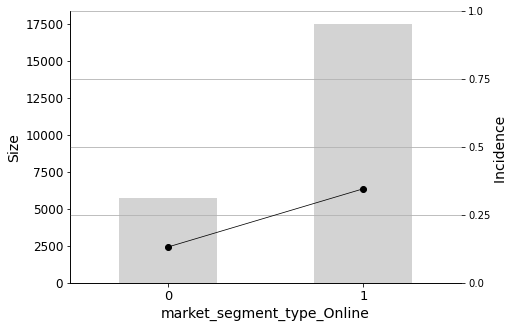

In [206]:
# Plot
_ = plot_pig(hotels_dummied, 'market_segment_type_Online', 'booking_status')

It seems that if the booking was made online, the chances of it being cancelled are clearly higher.

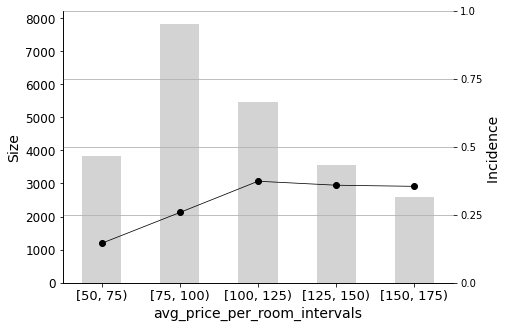

In [207]:
# Check minimum and maximum values to define range
hotels_dummied['avg_price_per_room'].agg([min, max])

# Establish price intervals according to value ranges
bins = pd.IntervalIndex.from_tuples([(i, i + 25) for i in range(50, 175, 25)], closed='left')

# Create new column with price intervals
hotels_dummied['avg_price_per_room_intervals'] = pd.cut(hotels_dummied['avg_price_per_room'], bins)

# Plot
_ = plot_pig(hotels_dummied, 'avg_price_per_room_intervals', 'booking_status')

Finally, the price of the room (a continuous variable that was also discretized) also has an important influence on predicting cancellations, especially in the range between low and medium-priced rooms.

## Conclusions

In summary, the main factors that contribute to the cancellation of bookings are:

- The lead time between the reservation and the arrival date.
- The number of special requests made by the customer.
- Whether the booking was made online.
- The price of the room.

To reduce the likelihood of cancellations, these variables should be closely monitored to produce a warning when the probability of cancellation reaches a certain level. Further actions should then be taken to address those customers.